In [1]:
# 添加搜索路径
import sys
sys.path.insert(0, "/root/mounted/projects/qpair/")

In [2]:
import os
import pickle
import numpy as np
import time, datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from config import * # 加载全局配置
from baselines import MODEL_WEM # 加载模型
from baselines import MODEL_WEM_ATTENTION

MODEL_WEIGHTS_FILE = './keras_saved_models/baseline_model_wem.h5'

KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/data_0520/intermediate/'
KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'kn_pairs_sampled_wids_cids_train.pkl')
KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'kn_pairs_sampled_wids_cids_test.pkl')

VALIDATION_SPLIT = 0.01
RNG_SEED = 13371447
NB_EPOCHS = 25
BATCH_SIZE = 1024

In [4]:
# 加载模型
model = MODEL_WEM()
# model = MODEL_WEM_ATTENTION()

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 39, 300)      6267600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 39, 300)      6267600     input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

In [6]:
# 加载数据集，并切分成train 和 validation
with open(KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL, 'rb') as f:
    kn_train_wids_cids_padded = pickle.load(f)

kn_train_wids_cids_padded.head()

,label,qid1,qid2,q1_q2_intersect,words1,chars1,words2,chars2
0,1,Q369872,Q425580,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,Q337191,Q425580,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,Q557247,Q425580,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,Q561687,Q425580,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,Q363774,Q425580,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
with open(KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL, 'rb') as f:
    kn_test_wids_cids_padded = pickle.load(f)

kn_test_wids_cids_padded

,label,qid1,qid2,q1_q2_intersect,words1,chars1,words2,chars2
0,1,Q292134,Q714141,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,Q336527,Q714141,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,Q180346,Q714141,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,Q390603,Q137731,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,Q390603,Q090092,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,1,Q634500,Q726317,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,1,Q197107,Q726317,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,1,Q682779,Q070021,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,1,Q682779,Q125927,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,0,Q390981,Q125927,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
q1_inputs = kn_train_wids_cids_padded['words1'].values
q2_inputs = kn_train_wids_cids_padded['words2'].values
inputs = np.stack((q1_inputs, q2_inputs), axis=1)
labels = kn_train_wids_cids_padded['label']
inputs_train, inputs_val, labels_train, labels_val = train_test_split(inputs, labels, test_size=VALIDATION_SPLIT, random_state=RNG_SEED)
q1_train = np.array(list(inputs_train[:,0]))
q2_train = np.array(list(inputs_train[:,1]))
q1_val = np.array(list(inputs_val[:,0]))
q2_val = np.array(list(inputs_val[:,1]))

In [9]:
inputs_train.shape, inputs_val.shape

((776964, 2), (7849, 2))

In [10]:
np.array(list(q1_train)).shape

(776964, 39)

In [11]:
q1_test_inputs = np.array(list(kn_test_wids_cids_padded['words1'].values))
q2_test_inputs = np.array(list(kn_test_wids_cids_padded['words2'].values))
labels_test = kn_test_wids_cids_padded['label']

In [12]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([q1_train, q2_train],
                    labels_train,
                    epochs=NB_EPOCHS,
                    validation_data = ([q1_test_inputs, q2_test_inputs], labels_test),
#                     validation_data = ([q1_val, q2_val], labels_val),
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-05-21 11:45:06.563256
Train on 776964 samples, validate on 15187 samples
Epoch 1/25
 - 16s - loss: 0.2552 - acc: 0.8923 - val_loss: 0.4129 - val_acc: 0.8405
Epoch 2/25
 - 15s - loss: 0.1332 - acc: 0.9492 - val_loss: 0.2555 - val_acc: 0.9064
Epoch 3/25
 - 15s - loss: 0.1034 - acc: 0.9619 - val_loss: 0.2661 - val_acc: 0.9050
Epoch 4/25
 - 15s - loss: 0.0872 - acc: 0.9683 - val_loss: 0.2255 - val_acc: 0.9248
Epoch 5/25
 - 15s - loss: 0.0749 - acc: 0.9733 - val_loss: 0.2228 - val_acc: 0.9245
Epoch 6/25
 - 15s - loss: 0.0682 - acc: 0.9759 - val_loss: 0.2046 - val_acc: 0.9305
Epoch 7/25
 - 15s - loss: 0.0618 - acc: 0.9781 - val_loss: 0.1795 - val_acc: 0.9409
Epoch 8/25
 - 15s - loss: 0.0560 - acc: 0.9803 - val_loss: 0.1851 - val_acc: 0.9385
Epoch 9/25
 - 15s - loss: 0.0513 - acc: 0.9821 - val_loss: 0.1495 - val_acc: 0.9521
Epoch 10/25
 - 15s - loss: 0.0473 - acc: 0.9836 - val_loss: 0.1730 - val_acc: 0.9452
Epoch 11/25
 - 15s - loss: 0.0441 - acc: 0.9848 - val_loss: 

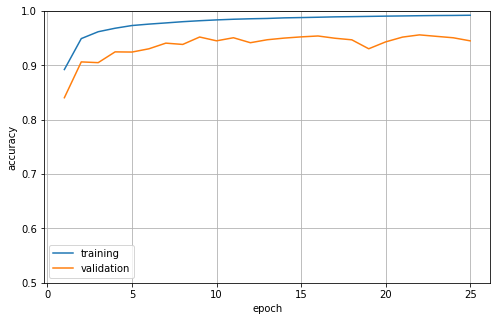

In [25]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.iloc[:,:].plot(x='epoch', figsize=(8,5), grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.5,1.0]);

In [14]:
history.history.keys()

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])

In [15]:
with open(TEST_WIDS_CIDS_PADDED_PKL, 'rb') as f:
    test_wids_cids_padded = pickle.load(f)
    
test_wids_cids_padded.head()

,qid1,qid2,words1,chars1,words2,chars2
0,Q345287,Q329078,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Q227821,Q460114,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Q449509,Q525440,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Q088371,Q364132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Q163532,Q114092,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
q1_test_inputs = np.array(list(test_wids_cids_padded['words1'].values))
q2_test_inputs = np.array(list(test_wids_cids_padded['words2'].values))
q1_test_inputs.shape

(24090, 39)

In [17]:
# 直接用最后一个epoch的模型
test_pred1 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred1 = test_pred1.squeeze()
test_pred1

array([0.9991856 , 0.99863976, 0.9628588 , ..., 0.00180873, 0.9994686 ,
       0.12684344], dtype=float32)

In [18]:
max(test_pred1), sum(test_pred1), sum(test_pred1) / 24090

(1.0, 18388.397290497014, 0.7633207675590292)

In [19]:
test_pred1_df = pd.DataFrame({'y_pre':test_pred1})
test_pred1_df

,y_pre
0,0.999186
1,0.998640
2,0.962859
3,0.986413
4,0.992845
5,0.698079
6,0.001078
7,0.494608
8,0.000752
9,0.000038


In [20]:
TEST_PRED_1 = './predicts/test_pred1.csv'
test_pred1_df.to_csv(TEST_PRED_1, index=False)

In [21]:
model.load_weights(MODEL_WEIGHTS_FILE)
test_pred2 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred2 = test_pred2.squeeze()
test_pred2

array([0.9879776 , 0.99179137, 0.99545234, ..., 0.00437265, 0.99717927,
       0.02641407], dtype=float32)

In [22]:
diff = test_pred2 - test_pred1
max(diff), sum(diff), sum(diff)/24090

(0.99585986, 895.2248596842425, 0.03716167952196939)